# Mining repos from GitHub

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from tqdm import tqdm

pd.options.display.float_format = "{:.2f}".format

## Get a list of good repos from GitHub Search

We set following filters at [GitHub Search](https://seart-ghs.si.usi.ch/):
* **50+** stars
* **1000+** commits
* **10+** contributors
* Created before **25 September 2021** (2+ years ago)
* Exclude Forks
* Has License

In [54]:
ghs_df = pd.read_csv("jan_2023_artifacts/ghs_results_25_jan_2023.csv", encoding_errors="ignore")
ghs_df

,name,isFork,commits,branches,defaultBranch,releases,contributors,license,watchers,stargazers,...,homepage,mainLanguage,totalIssues,openIssues,totalPullRequests,openPullRequests,lastCommit,lastCommitSHA,hasWiki,isArchived
0,sparklemotion/nokogiri,False,6557,30,main,44,214,MIT License,159,5930,...,https://nokogiri.org/,C,1833.00,101.00,791.00,15.00,2022-11-17T09:43:39,e9bafd0fc6868e1715ce96dc4a6cfd14f72e852e,True,False
1,davidb/scala-maven-plugin,False,1036,6,master,0,59,The Unlicense,21,525,...,https://davidb.github.io/scala-maven-plugin/,Java,264.00,1.00,397.00,6.00,2023-01-13T06:29:47,09ecd030c524f7dc5a24ea5917fb5e1e80125e20,True,False
2,junit-team/junit4,False,2502,5,main,13,146,Eclipse Public License 1.0,594,8398,...,https://junit.org/junit4,Java,821.00,108.00,895.00,20.00,2022-12-10T07:47:28,b6d496aaf4d48cd7b483c742d74b98f3892dbee4,True,False
3,mongodb/mongo-java-driver,False,8066,47,master,127,153,Apache License 2.0,221,2524,...,https://mongodb.github.io/mongo-java-driver,Java,0.00,0.00,1062.00,9.00,2022-12-19T06:17:30,6f7170348757633928ccd2529d325b95f1cab75a,True,False
4,unclebob/fitnesse,False,5992,2,master,1,109,Other,155,1864,...,fitnesse.org,Java,728.00,88.00,660.00,4.00,2022-11-06T08:57:06,b851f6ef37ec82b77818296c95bad89b2f69d9e1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24922,ircam-wam/timeside,False,3720,72,master,6,17,GNU Affero General Public License v3.0,26,341,...,https://timeside.ircam.fr/docs/,Python,213.00,47.00,97.00,0.00,2023-01-06T12:00:29,d6a7024879919ac37a31d99eb9df3b87bc22491d,True,False
24923,mathiasertl/django-ca,False,5820,26,main,31,11,GNU General Public License v3.0,9,103,...,NaN,Python,62.00,2.00,36.00,0.00,2023-01-08T04:50:02,06673c5176f7f19e21dc97edb090ff6ade3e2dee,False,False
24924,enthought/traitsui,False,4723,44,main,21,71,Other,69,283,...,http://docs.enthought.com/traitsui,Python,918.00,411.00,1066.00,15.00,2023-01-12T02:40:54,d8a5be640c184f7eada7a6d2c9cbb1ad81f2482e,True,False
24925,r-spatial/mapview,False,1818,9,master,1,19,GNU General Public License v3.0,38,448,...,https://r-spatial.github.io/mapview/,JavaScript,396.00,73.00,51.00,0.00,2023-01-06T09:30:46,64f865a23d8587e7f822e26ed7e3bbfe1f4829e4,True,False


In [55]:
ghs_df.columns

Index(['name', 'isFork', 'commits', 'branches', 'defaultBranch', 'releases',
       'contributors', 'license', 'watchers', 'stargazers', 'forks', 'size',
       'createdAt', 'pushedAt', 'updatedAt', 'homepage', 'mainLanguage',
       'totalIssues', 'openIssues', 'totalPullRequests', 'openPullRequests',
       'lastCommit', 'lastCommitSHA', 'hasWiki', 'isArchived'],
      dtype='object')

## Get additional info through GitHub API

Next, we collect additional information about these repos via official GitHub API.

In [14]:
from github import Github
from github.GithubException import RateLimitExceededException, UnknownObjectException, GithubException

# using an access token
with open("jan_2023_artifacts/access_token.txt") as file:
    access_token = file.readline().strip()

g = Github(access_token)

In [129]:
import calendar
import time
import datetime
import logging
import jsonlines
import os

logger = logging.getLogger("query_api")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler("jan_2023_artifacts/api.log")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter("%(asctime)s | %(levelname)s | %(message)s"))
logger.addHandler(fh)


github_metadata_path = "jan_2023_artifacts/repos_metadata.jsonl"


names = ghs_df["name"].tolist()
if os.path.exists(github_metadata_path):
    with jsonlines.open(github_metadata_path, "r") as reader:
        processed_names = set(line["name"] for line in reader)
    logger.info(f"Already processed {len(processed_names)} repositories!")
    names = [name for name in names if name not in processed_names]
    logger.info(f"{len(names)} repositories left!")
else:
    open(github_metadata_path, "w").close()

INFO:query_api:Already processed 24927 repositories!
INFO:query_api:0 repositories left!


In [130]:
cur_chunk = []
chunksize = 1000

for name in tqdm(names):
    try:
        repo = g.get_repo(name)
        data = {
            "name": name,
            "github_full_name": repo.full_name,
            "github_url": repo.git_url,
            "github_language": repo.language,
        }
    except RateLimitExceededException:
        core_rate_limit = g.get_rate_limit().core
        reset_timestamp = calendar.timegm(core_rate_limit.reset.timetuple())
        sleep_time = reset_timestamp - calendar.timegm(time.gmtime()) + 5
        logger.info(f"{datetime.datetime.now()} Rate Limit exceeded! Sleeping for {sleep_time // 60} minutes")
        if len(cur_chunk) > 0:
            with jsonlines.open(github_metadata_path, "a") as writer:
                writer.write_all(cur_chunk)
                cur_chunk = []
        time.sleep(sleep_time)
        repo = g.get_repo(name)
        data = {
            "name": name,
            "github_full_name": repo.full_name,
            "github_url": repo.git_url,
            "github_language": repo.language,
        }
    except UnknownObjectException:
        logger.warning(f"Unknown object exception with repo {name}")
        data = {"name": name, "github_full_name": None, "github_url": None, "github_language": None}
    except GithubException:
        logger.warning(f"GitHub exception with repo {name}")
        data = {"name": name, "github_full_name": None, "github_url": None, "github_language": None}

    cur_chunk.append(data)
    if len(cur_chunk) > chunksize:
        with jsonlines.open(github_metadata_path, "a") as writer:
            writer.write_all(cur_chunk)
            cur_chunk = []

if cur_chunk:
    with jsonlines.open(github_metadata_path, "a") as writer:
        writer.write_all(cur_chunk)
        cur_chunk = []

0it [00:00, ?it/s]


## Merge with Github Search data

In [131]:
github_metadata = pd.read_json(github_metadata_path, orient="records", lines=True)
github_metadata

,name,github_full_name,github_url,github_language
0,sparklemotion/nokogiri,sparklemotion/nokogiri,git://github.com/sparklemotion/nokogiri.git,C
1,davidb/scala-maven-plugin,davidB/scala-maven-plugin,git://github.com/davidB/scala-maven-plugin.git,Java
2,junit-team/junit4,junit-team/junit4,git://github.com/junit-team/junit4.git,Java
3,mongodb/mongo-java-driver,mongodb/mongo-java-driver,git://github.com/mongodb/mongo-java-driver.git,Java
4,unclebob/fitnesse,unclebob/fitnesse,git://github.com/unclebob/fitnesse.git,Java
...,...,...,...,...
24922,ircam-wam/timeside,Ircam-WAM/TimeSide,git://github.com/Ircam-WAM/TimeSide.git,Python
24923,mathiasertl/django-ca,mathiasertl/django-ca,git://github.com/mathiasertl/django-ca.git,Python
24924,enthought/traitsui,enthought/traitsui,git://github.com/enthought/traitsui.git,Python
24925,r-spatial/mapview,r-spatial/mapview,git://github.com/r-spatial/mapview.git,JavaScript


Luckily, we only have 3 repositories that returned errors when querying GitHub API.

In [132]:
github_metadata.loc[github_metadata.github_full_name.isnull()]

,name,github_full_name,github_url,github_language
2276,apollofoundation/apollo,None,None,None
7647,maxrd2/subtitlecomposer,None,None,None
15273,oncletom/nodebook,None,None,None


In [133]:
ghs_df = pd.read_csv("jan_2023_artifacts/ghs_results_25_jan_2023.csv", encoding_errors="ignore")
ghs_df = ghs_df.merge(github_metadata, on="name", how="inner")
ghs_df = ghs_df.loc[~ghs_df.github_full_name.isna()]
ghs_df.groupby("mainLanguage").agg(num_repos=("name", "count"), num_commits=("commits", "sum"))

,num_repos,num_commits
mainLanguage,,
C,2158,52713671
C#,1181,4756205
C++,2896,26958594
Dart,95,327673
Elixir,71,208843
Go,1576,6248401
Groovy,52,288245
Java,2862,17373734
JavaScript,3509,13643678


## Filter!

Next filtering steps:

1. Only keep repositories with Apache License 2.0, MIT License, BSD 3-Clause New or Revised License
2. Drop duplicates by `full_name` property (which might appear due to renaming/transferring/mirroring repositories)

In [134]:
ghs_df["license"].unique()

array(['MIT License', 'The Unlicense', 'Eclipse Public License 1.0',
       'Apache License 2.0', 'Other', 'GNU General Public License v2.0',
       'GNU General Public License v3.0',
       'BSD 3-Clause New or Revised License',
       'GNU Lesser General Public License v2.1',
       'GNU Lesser General Public License v3.0', 'ISC License',
       'GNU Affero General Public License v3.0',
       'BSD 2-Clause Simplified License', 'Eclipse Public License 2.0',
       'BSD 4-Clause Original or Old License',
       'Mozilla Public License 2.0',
       'Creative Commons Zero v1.0 Universal',
       'Creative Commons Attribution Share Alike 4.0 International',
       'Open Software License 3.0', 'Universal Permissive License v1.0',
       'European Union Public License 1.2',
       'Educational Community License v2.0',
       'CeCILL Free Software License Agreement v2.1',
       'Artistic License 2.0',
       'Do What The F*ck You Want To Public License', 'zlib License',
       'University 

In [135]:
# keep repos only with Apache / MIT / BSD license
filtered_df = ghs_df.loc[
    ghs_df["license"].isin(["Apache License 2.0", "MIT License", "BSD 3-Clause New or Revised License"])
]
logger.info(
    f"After dropping repos without Apache/MIT/BSD licences: {len(filtered_df)}, diff with previous step: {len(ghs_df) - len(filtered_df)} ({(len(ghs_df) - len(filtered_df)) / len(ghs_df) * 100 :.2f}%)"
)
prev_len = len(filtered_df)

# drop duplicate repos
filtered_df = filtered_df.drop_duplicates(subset=["github_full_name"])
print(
    f"After dropping full_name duplicates: {len(filtered_df)}, diff with previous step: {prev_len - len(filtered_df)} ({(prev_len - len(filtered_df)) / prev_len * 100 :.2f}%)"
)

INFO:query_api:After dropping repos without Apache/MIT/BSD licences: 12921, diff with previous step: 12003 (48.16%)


After dropping full_name duplicates: 12404, diff with previous step: 517 (4.00%)


So we dropped about half of repositories. What about statistics by languages?

In [136]:
ghs_stats = ghs_df.groupby("mainLanguage").agg(num_repos=("name", "count"), num_commits=("commits", "sum"))
filtered_stats = filtered_df.groupby("mainLanguage").agg(num_repos=("name", "count"), num_commits=("commits", "sum"))
filtered_stats["percent_repos"] = filtered_stats["num_repos"] / ghs_stats["num_repos"] * 100
filtered_stats["percent_commits"] = filtered_stats["num_commits"] / ghs_stats["num_commits"] * 100
filtered_stats

,num_repos,num_commits,percent_repos,percent_commits
mainLanguage,,,,
C,411,1995605,19.05,3.79
C#,662,2307941,56.05,48.52
C++,887,6735601,30.63,24.98
Dart,61,239779,64.21,73.18
Elixir,47,144044,66.20,68.97
Go,1091,3794549,69.23,60.73
Groovy,42,233348,80.77,80.95
Java,1515,7125050,52.94,41.01
JavaScript,1983,6660977,56.51,48.82


In [137]:
filtered_df.to_json("jan_2023_artifacts/filtered_ghs_results_25_jan_2023.jsonl", orient="records", lines=True)

## Train/val/test split

In [138]:
filtered_df = pd.read_json("jan_2023_artifacts/filtered_ghs_results_25_jan_2023.jsonl", orient="records", lines=True)

In [139]:
filtered_df

,name,isFork,commits,branches,defaultBranch,releases,contributors,license,watchers,stargazers,...,openIssues,totalPullRequests,openPullRequests,lastCommit,lastCommitSHA,hasWiki,isArchived,github_full_name,github_url,github_language
0,sparklemotion/nokogiri,False,6557,30,main,44,214,MIT License,159,5930,...,101.00,791.00,15.00,2022-11-17T09:43:39,e9bafd0fc6868e1715ce96dc4a6cfd14f72e852e,True,False,sparklemotion/nokogiri,git://github.com/sparklemotion/nokogiri.git,C
1,mongodb/mongo-java-driver,False,8066,47,master,127,153,Apache License 2.0,221,2524,...,0.00,1062.00,9.00,2022-12-19T06:17:30,6f7170348757633928ccd2529d325b95f1cab75a,True,False,mongodb/mongo-java-driver,git://github.com/mongodb/mongo-java-driver.git,Java
2,connectbot/connectbot,False,2092,18,main,521,52,Apache License 2.0,125,1957,...,278.00,707.00,19.00,2022-08-23T05:53:47,7b6973f5ad330b22d2a085ef37744632c0c86a0b,True,False,connectbot/connectbot,git://github.com/connectbot/connectbot.git,Java
3,rnewson/couchdb-lucene,False,1127,18,master,7,23,Apache License 2.0,36,763,...,71.00,49.00,12.00,2022-02-04T12:46:02,8423f15c345a873bc49da863fafe7212203b7164,False,False,rnewson/couchdb-lucene,git://github.com/rnewson/couchdb-lucene.git,Java
4,apache/zookeeper,False,2435,26,master,0,171,Apache License 2.0,664,10899,...,0.00,1936.00,218.00,2022-10-11T08:23:12,90f813ea38a85ff2715662bad75f9bb6387fe4a6,False,False,apache/zookeeper,git://github.com/apache/zookeeper.git,Java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12399,flutter/flutter,False,32865,454,master,0,386,BSD 3-Clause New or Revised License,3558,148323,...,11256.00,40635.00,186.00,2023-01-13T11:34:33,68dd63d66ba6359b377a48c3bb4b028ab5ef5140,True,False,flutter/flutter,git://github.com/flutter/flutter.git,Dart
12400,simolus3/drift,False,2916,12,develop,27,90,MIT License,36,1824,...,101.00,239.00,2.00,2023-01-13T11:02:58,417fd3066489d24a166e82a2be0aa49a1093e5eb,True,False,simolus3/drift,git://github.com/simolus3/drift.git,Dart
12401,autozimu/languageclient-neovim,False,1686,9,next,153,116,MIT License,41,3465,...,97.00,431.00,20.00,2022-06-07T07:49:39,cf6dd11baf62fb6ce18308e96c0ab43428b7c686,True,False,autozimu/LanguageClient-neovim,git://github.com/autozimu/LanguageClient-neovi...,Rust
12402,thulab/iot-benchmark,False,1241,5,master,7,34,Apache License 2.0,20,143,...,4.00,273.00,2.00,2023-01-04T12:16:40,ed2b03ff9f426fb84811a29dc59509db8d15ef5e,True,False,thulab/iot-benchmark,git://github.com/thulab/iot-benchmark.git,Java


In [140]:
from sklearn.model_selection import train_test_split


train_repos, val_test_repos = train_test_split(
    filtered_df.name, test_size=0.2, stratify=filtered_df.mainLanguage, random_state=42
)
val_repos, test_repos = train_test_split(
    val_test_repos,
    test_size=0.5,
    stratify=filtered_df.loc[filtered_df.name.isin(val_test_repos)].mainLanguage,
    random_state=42,
)

In [141]:
parts = {
    "train": filtered_df.loc[filtered_df.name.isin(train_repos)],
    "val": filtered_df.loc[filtered_df.name.isin(val_repos)],
    "test": filtered_df.loc[filtered_df.name.isin(test_repos)],
}

for part in parts:
    print(part, len(parts[part]), f"{len(parts[part]) / len(filtered_df) * 100:.2f}")
    parts[part].to_json(f"jan_2023_artifacts/{part}_25_jan_2023.jsonl", orient="records", lines=True)

train 9923 80.00
val 1240 10.00
test 1241 10.00


In [145]:
dfs = [
    filtered_df.groupby("mainLanguage").agg(num_repos=("name", "count"), num_commits=("commits", "sum")).reset_index()
]
dfs[0]["part"] = "full"
for part in ["train", "val", "test"]:
    part_df = pd.read_json(f"jan_2023_artifacts/{part}_25_jan_2023.jsonl", orient="records", lines=True)
    _ = part_df.groupby("mainLanguage").agg(num_repos=("name", "count"), num_commits=("commits", "sum")).reset_index()
    _["part"] = part
    dfs.append(_)
df = pd.concat(dfs, axis=0, ignore_index=True)

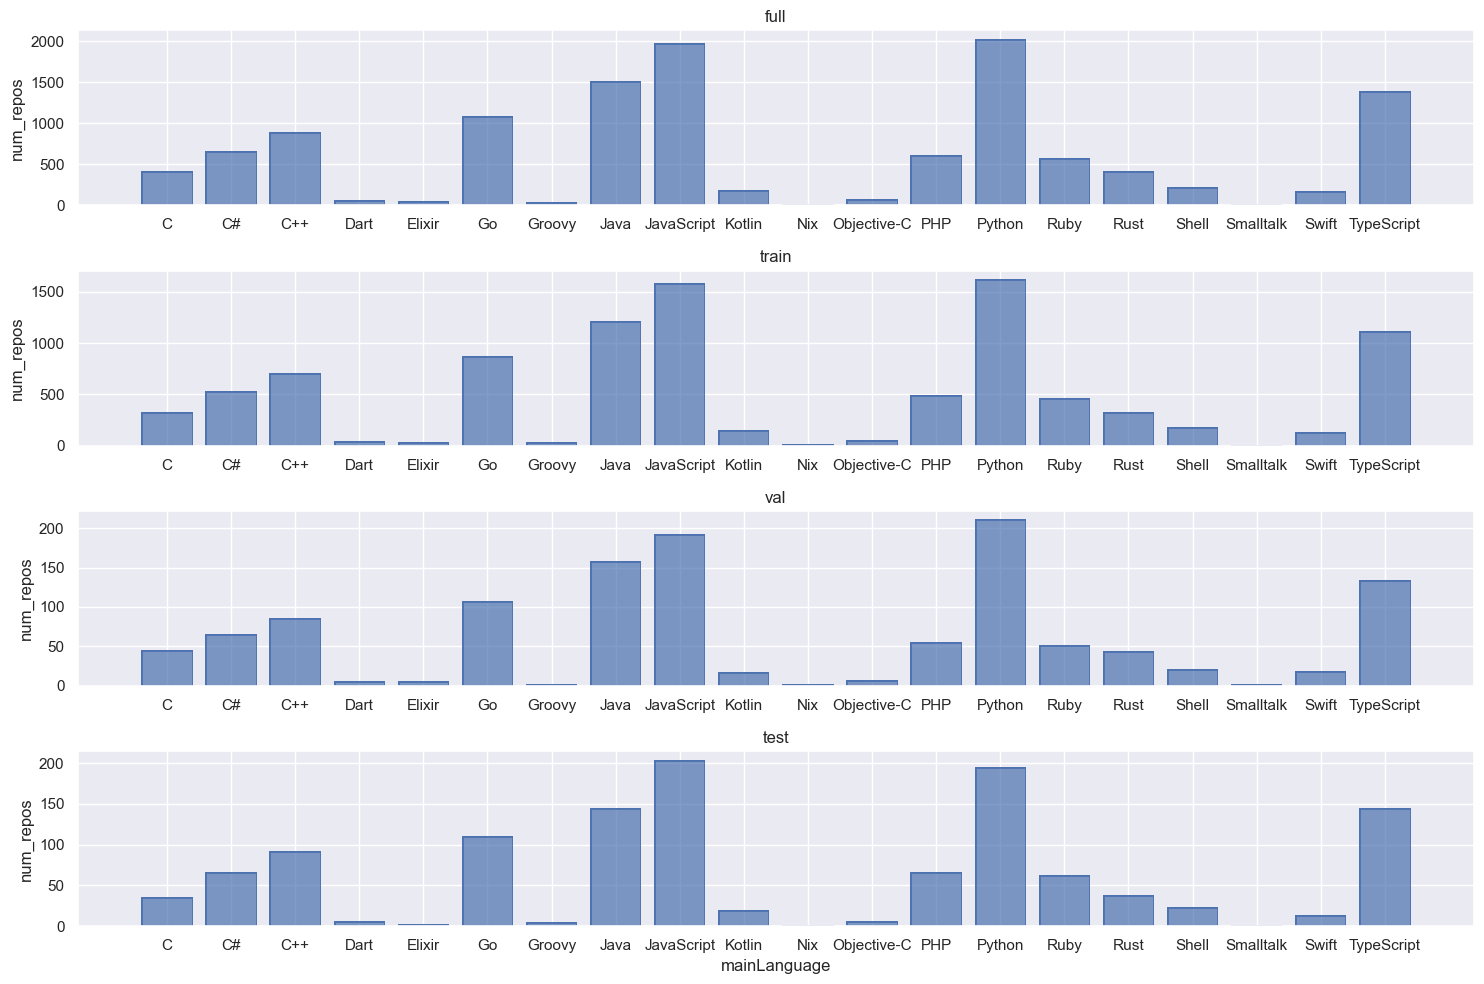

In [146]:
import seaborn.objects as so


(
    so.Plot(df, x="mainLanguage", y="num_repos")
    .add(so.Bar())
    .facet("part", wrap=1)
    .share(x=False, y=False)
    .layout(size=(15, 10))
    .show()
)

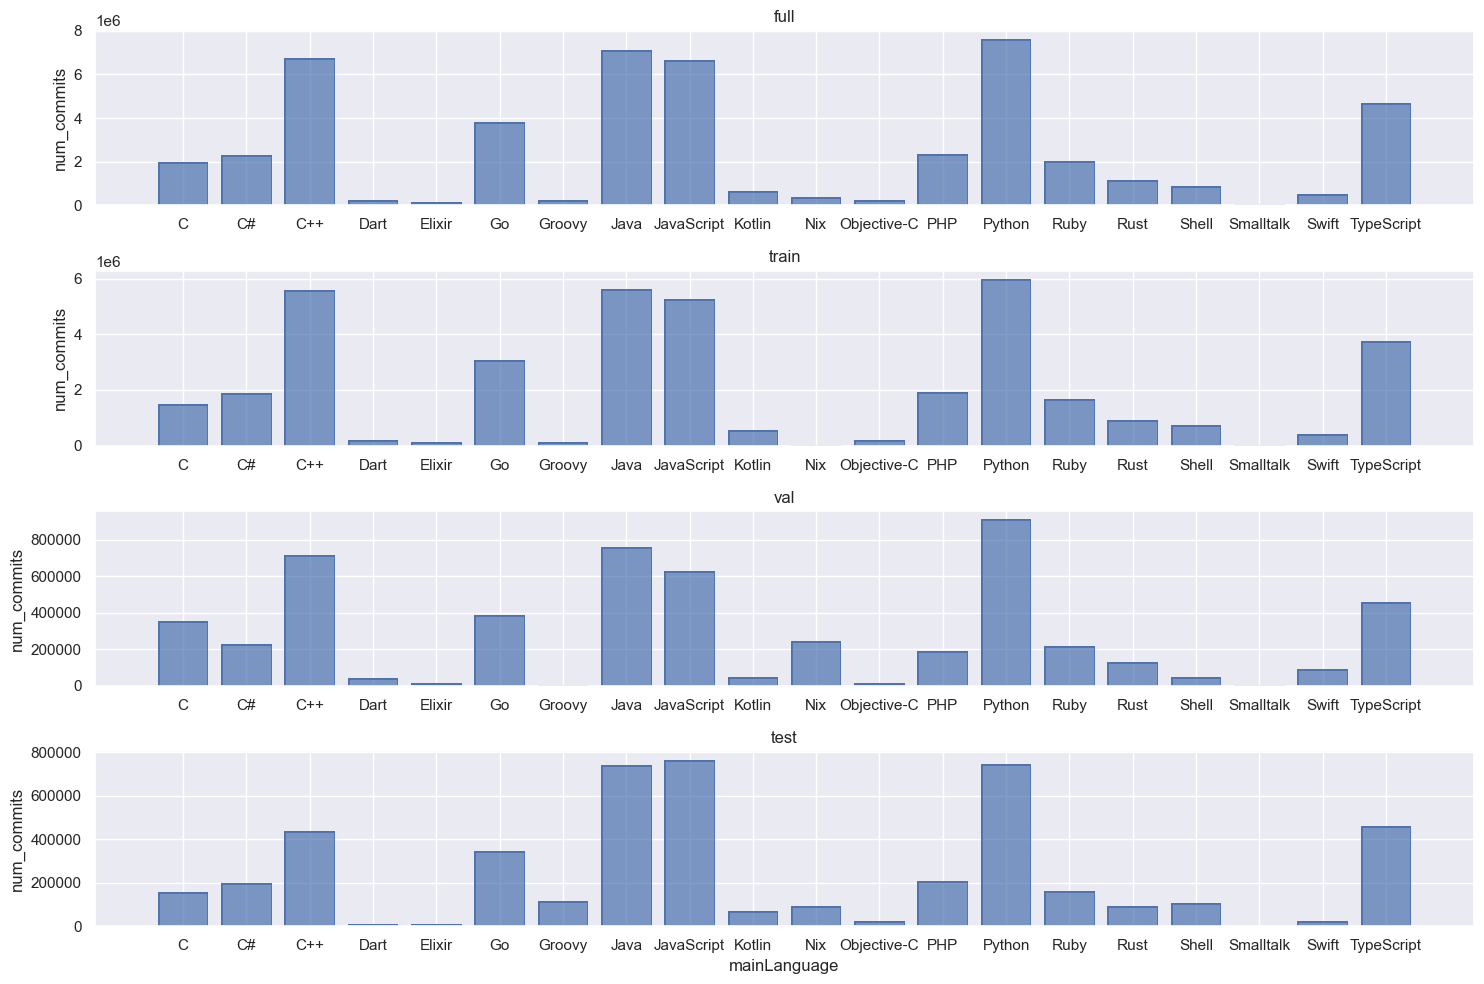

In [150]:
(
    so.Plot(df, x="mainLanguage", y="num_commits")
    .add(so.Bar())
    .facet("part", wrap=1)
    .share(x=False, y=False)
    .layout(size=(15, 10))
    .show()
)